> **Import Libraries**

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

> **Loading Dataset**

In [3]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazimulrahman","key":"e95a9727271c4b772b1591a2095a816a"}'}

In [5]:
import opendatasets as od

# Create the .kaggle directory and copy the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
od.download("https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis", force=True)

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/market-basket-analysis


100%|██████████| 22.8M/22.8M [00:00<00:00, 892MB/s]

In [6]:
# Load the dataset
df = pd.read_excel('/content/market-basket-analysis/Assignment-1_Data.xlsx')

In [7]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [8]:
# Data cleaning
df = df.dropna(subset=['Itemname', 'CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(str)
df['BillNo'] = df['BillNo'].astype(str)

In [9]:
# Create revenue feature
df['Revenue'] = df['Quantity'] * df['Price']

In [10]:
# Filter out negative quantities (returns)
df = df[df['Quantity'] > 0]

In [11]:
print(f"Cleaned dataset contains {len(df)} transactions")

Cleaned dataset contains 388023 transactions


> **Feature Engineering**

In [12]:
# Extract date features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour

In [13]:

# Create time-based segments
df['TimeOfDay'] = pd.cut(df['Hour'],
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                         right=False)

In [14]:
# Create price segments
df['PriceSegment'] = pd.qcut(df['Price'],
                            q=4,
                            labels=['Low', 'Medium', 'High', 'Premium'])

In [15]:
# Create country groups (focus on top countries)
top_countries = df['Country'].value_counts().head(5).index
df['CountryGroup'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

> **Transaction Analysis**

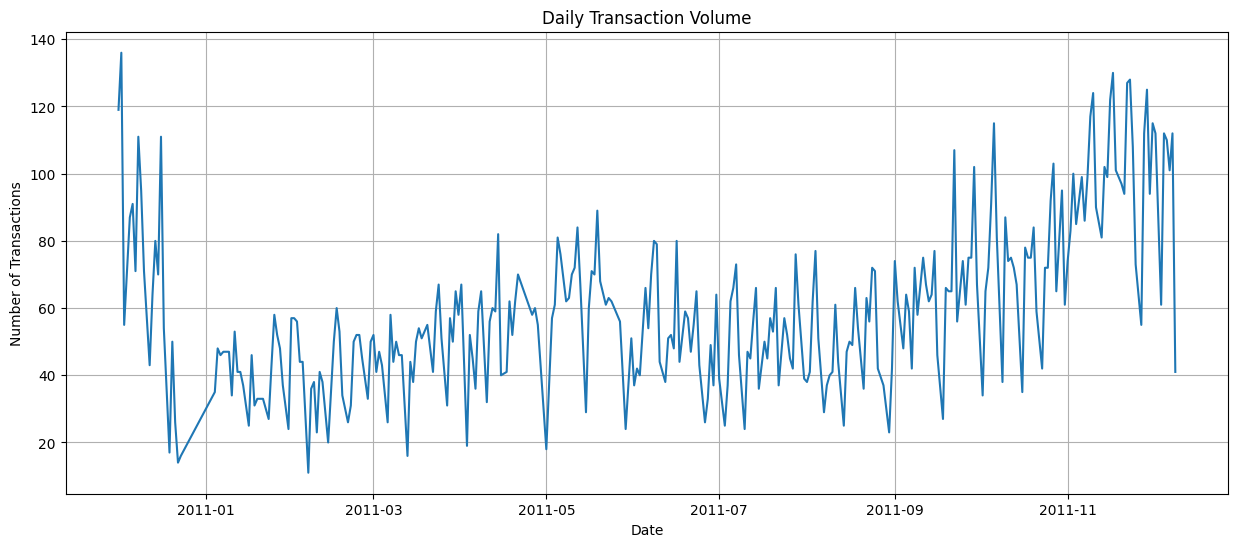

In [16]:
# Transaction volume over time
plt.figure(figsize=(15, 6))
df.groupby(df['Date'].dt.date)['BillNo'].nunique().plot()
plt.title('Daily Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid()
plt.show()

In [17]:
# Average items per transaction
avg_items = df.groupby('BillNo')['Quantity'].sum().mean()
print(f"Average items per transaction: {avg_items:.2f}")

Average items per transaction: 275.42


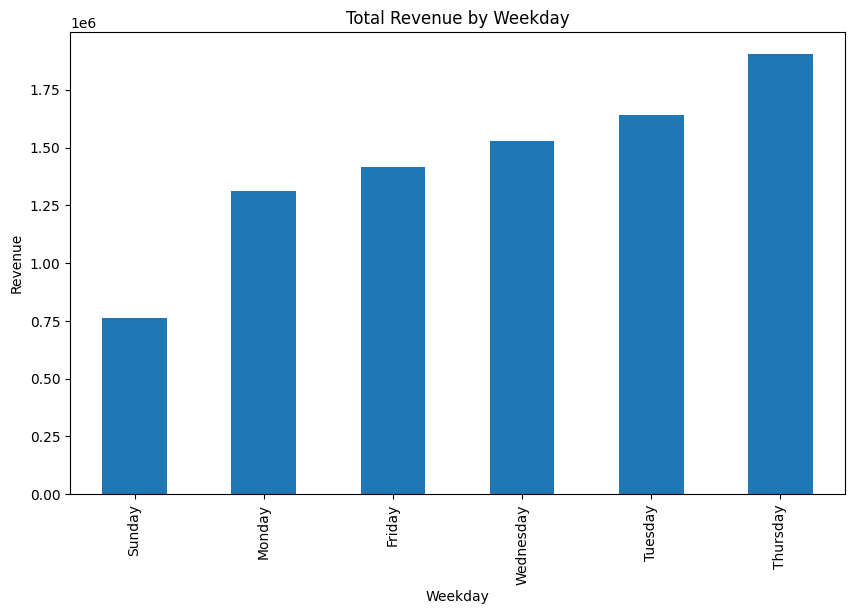

In [18]:
# Revenue distribution by weekday
plt.figure(figsize=(10, 6))
df.groupby('Weekday')['Revenue'].sum().sort_values().plot(kind='bar')
plt.title('Total Revenue by Weekday')
plt.ylabel('Revenue')
plt.show()

> **Product Analysis**

In [19]:
# Top products by revenue
top_products_rev = df.groupby('Itemname')['Revenue'].sum().sort_values(ascending=False).head(20)

In [20]:
# Top products by quantity
top_products_qty = df.groupby('Itemname')['Quantity'].sum().sort_values(ascending=False).head(20)

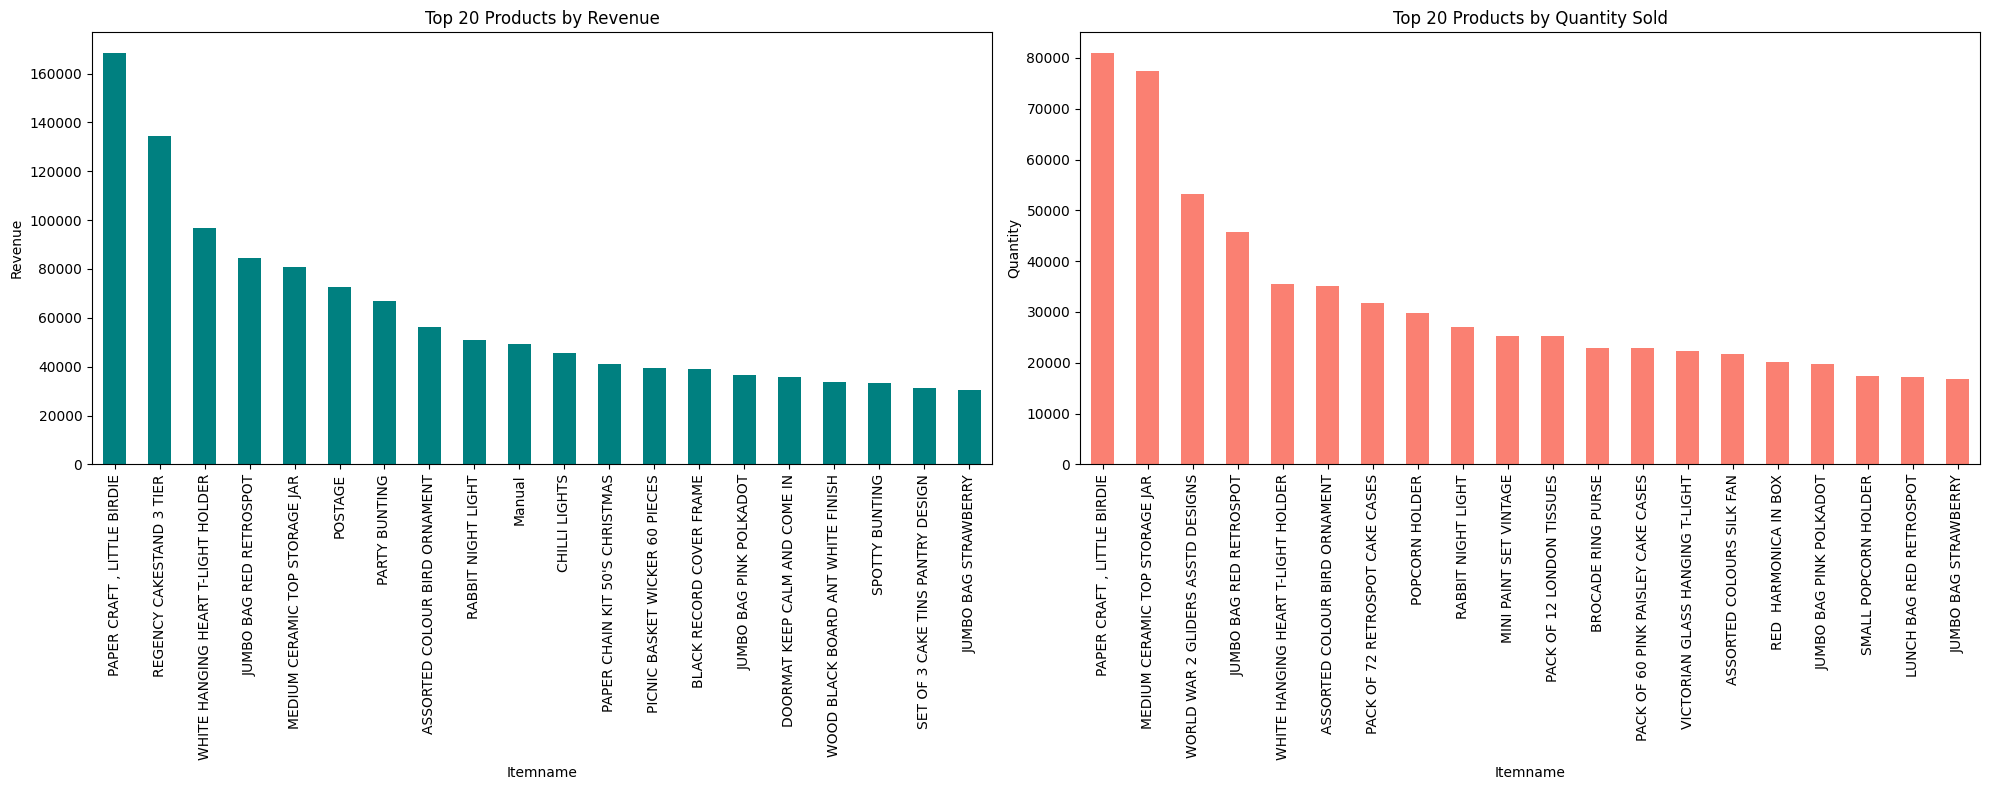

In [21]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
top_products_rev.plot(kind='bar', ax=ax[0], color='teal')
ax[0].set_title('Top 20 Products by Revenue')
ax[0].set_ylabel('Revenue')

top_products_qty.plot(kind='bar', ax=ax[1], color='salmon')
ax[1].set_title('Top 20 Products by Quantity Sold')
ax[1].set_ylabel('Quantity')

plt.tight_layout()
plt.show()

> **Data Preparation for Association Rules**

In [22]:
# Create basket data (items bought together in each transaction)
basket = df.groupby(['BillNo', 'Itemname'])['Quantity'].sum().unstack().fillna(0)

In [23]:
# Convert to binary (1 if item was purchased, 0 otherwise)
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)

In [24]:
# Filter for frequent items (appear in at least 1% of transactions)
item_freq = basket_sets.sum() / len(basket_sets)
frequent_items = item_freq[item_freq >= 0.01].index
basket_sets = basket_sets[frequent_items]

In [25]:
print(f"Final basket matrix shape: {basket_sets.shape}")

Final basket matrix shape: (18163, 619)


> **Association Rule Mining**

In [26]:
# Define dynamic min_support
def dynamic_min_support(item_freq):
    """
    Calculate dynamic minimum support based on relative item frequency.
    High-frequency items can afford lower thresholds, low-frequency items get higher thresholds.
    """
    return np.where(item_freq > 0.05, 0.01,     # High freq → low min_support
                  np.where(item_freq > 0.02, 0.02,  # Medium freq
                          0.03))                   # Low freq → higher min_support

In [27]:
# Apply dynamic support to itemset filtering Assume item_freq is a pandas Series
# with item frequency (e.g. basket_sets.sum() / len(basket_sets))
item_freq = basket_sets.sum() / len(basket_sets)
dynamic_support = pd.Series(dynamic_min_support(item_freq), index=item_freq.index)

In [28]:
# Filter basket by dynamically supported items only
selected_items = dynamic_support[dynamic_support <= 0.02].index
filtered_basket = basket_sets[selected_items]

In [ ]:
#  Generate frequent itemsets using FP-Growth (faster than Apriori)
frequent_itemsets = fpgrowth(filtered_basket,
                             min_support=0.01,  # Initial lower bound; already filtered by dynamic support
                             use_colnames=True,
                             max_len=5)

In [ ]:
# Generate association rules
rules = association_rules(frequent_itemsets,
                          metric="lift",
                          min_threshold=1,
                          support_only=False)

In [ ]:
# Add extra metrics for deeper insight
rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])
rules['conviction'] = (1 - rules['consequent support']) / (1 - rules['confidence'])

In [ ]:
# Optional: Add Zhang's Metric (interestingness)
rules['zhangs_metric'] = (rules['support'] - (rules['antecedent support'] * rules['consequent support'])) / \
                         np.maximum(rules['support'], rules['antecedent support'] * rules['consequent support'])

In [ ]:
# Filter strong rules
strong_rules = rules[
    (rules['lift'] >= 3) &
    (rules['confidence'] >= 0.3) &
    (rules['support'] >= 0.01) &
    (rules['leverage'] > 0.001)
]

In [ ]:
# Output results
print(f"Generated {len(strong_rules)} strong association rules")

In [ ]:
# Optional: sort and view top rules
print(strong_rules.sort_values(by='lift', ascending=False).head(10))

> **Network Graph Visualization**

In [ ]:
# Create network graph of association rules
def draw_network(rules, rules_to_show=20):
    plt.figure(figsize=(15, 15))

    # Create directed graph
    G = nx.DiGraph()

    # Add nodes and edges
    for _, rule in rules.head(rules_to_show).iterrows():
        G.add_node(str(rule['antecedents']))
        G.add_node(str(rule['consequents']))
        G.add_edge(str(rule['antecedents']),
                  str(rule['consequents']),
                  weight=rule['lift'])

    # Position nodes using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, alpha=0.6, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3,
                          edge_color='gray',
                          width=[d['weight']*0.1 for _, _, d in G.edges(data=True)])

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9,
                           bbox=dict(facecolor='white', alpha=0.8))

    plt.title('Association Rules Network (Edge Weight = Lift)', fontsize=15)
    plt.axis('off')
    plt.show()

draw_network(strong_rules)

> **Scatter Plot: Support vs Confidence**

In [ ]:
# Set plotting style
sns.set(style="whitegrid")
#  Scatter Plot: Support vs Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(data=strong_rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', sizes=(50, 300))
plt.title('Association Rules: Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift')
plt.show()

> **Heatmap: Support vs Lift**

In [ ]:
# Set plotting style
sns.set(style="whitegrid")
#  Heatmap: Support vs Lift
pivot = strong_rules.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='mean')

plt.figure(figsize=(16, 14))
sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Lift Heatmap (Antecedents vs Consequents)')
plt.xlabel('Consequent')
plt.ylabel('Antecedent')
plt.show()

> **Parallel Coordinates Plot**





In [ ]:
def prepare_parallel_coordinates_advanced(rules, top_n=15):
    """Prepare and normalize data for parallel coordinates plotting."""
    # Copy rules and select top N by lift
    selected_rules = rules.sort_values(by='lift', ascending=False).head(top_n).copy()

    # Flatten antecedents/consequents
    selected_rules['antecedent'] = selected_rules['antecedents'].apply(lambda x: ', '.join(sorted(x)))
    selected_rules['consequent'] = selected_rules['consequents'].apply(lambda x: ', '.join(sorted(x)))
    selected_rules['rule'] = selected_rules['antecedent'] + ' ➝ ' + selected_rules['consequent']

    # Normalize the metrics to [0,1] range
    scaler = MinMaxScaler()
    metrics = ['support', 'confidence', 'lift']
    selected_rules[metrics] = scaler.fit_transform(selected_rules[metrics])

    # Select and return columns
    return selected_rules[['rule', 'support', 'confidence', 'lift']]

In [ ]:
# Prepare data
parallel_rules = prepare_parallel_coordinates_advanced(strong_rules)

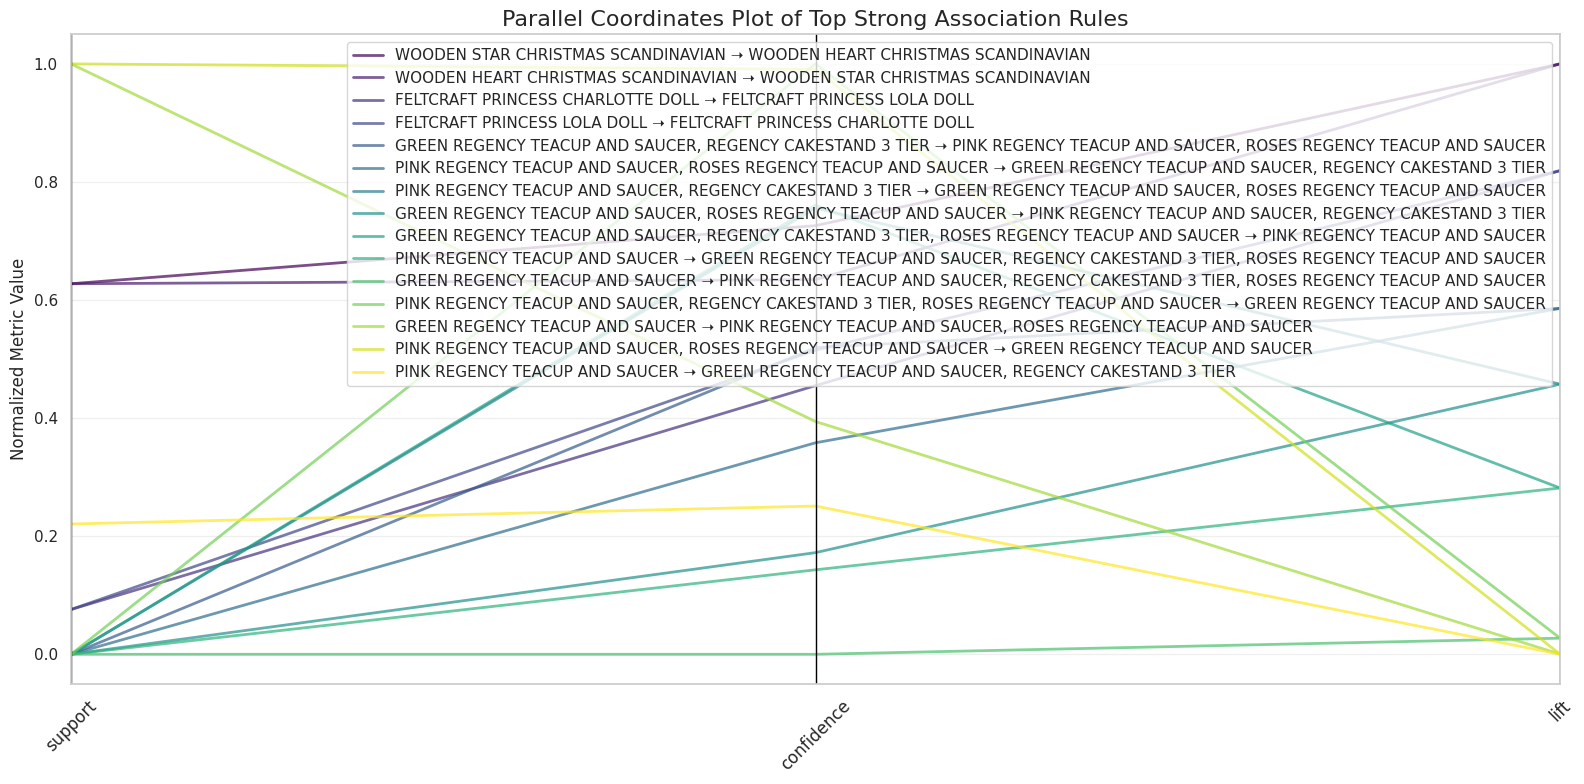

In [ ]:
# Create parallel coordinates plot
plt.figure(figsize=(16, 8))
pd.plotting.parallel_coordinates(parallel_rules, 'rule',
                                 colormap='viridis',
                                 alpha=0.7, linewidth=2)

plt.xticks(rotation=45, fontsize=12)
plt.title('Parallel Coordinates Plot of Top Strong Association Rules', fontsize=16)
plt.ylabel("Normalized Metric Value")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> **Rule Filtering and Interpretation**

In [ ]:
# Filter rules by product categories
def filter_rules_by_category(rules, category_keywords):
    """Filter rules where antecedents or consequents contain any of the keywords"""
    filtered = rules[
        rules['antecedents'].apply(lambda x: any(keyword in str(item).lower() for item in x for keyword in category_keywords)) |
        rules['consequents'].apply(lambda x: any(keyword in str(item).lower() for item in x for keyword in category_keywords))
    ]
    return filtered

In [ ]:
# Filter for rules involving bags
bag_rules = filter_rules_by_category(strong_rules, ['bag', 'storage', 'jumbo'])
print(f"Found {len(bag_rules)} rules related to bags")

Found 351 rules related to bags


In [ ]:
# Display top bag-related rules
bag_rules.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
848,(JUMBO BAG VINTAGE CHRISTMAS),(JUMBO BAG 50'S CHRISTMAS),0.021,0.032,0.013,0.637,19.977,1.000,0.013,2.666,0.950,0.338,0.625,0.527
849,(JUMBO BAG 50'S CHRISTMAS),(JUMBO BAG VINTAGE CHRISTMAS),0.032,0.021,0.013,0.418,19.977,1.000,0.013,1.682,0.950,0.338,0.406,0.527
822,(LUNCH BAG DOILEY PATTERN),(JUMBO BAG DOILEY PATTERNS),0.025,0.025,0.012,0.463,18.683,1.000,0.011,1.816,0.946,0.305,0.449,0.467
823,(JUMBO BAG DOILEY PATTERNS),(LUNCH BAG DOILEY PATTERN),0.025,0.025,0.012,0.471,18.683,1.000,0.011,1.843,0.946,0.305,0.457,0.467
817,(JUMBO BAG PEARS),(JUMBO BAG APPLES),0.025,0.039,0.017,0.667,17.175,1.000,0.016,2.884,0.942,0.359,0.653,0.552
816,(JUMBO BAG APPLES),(JUMBO BAG PEARS),0.039,0.025,0.017,0.437,17.175,1.000,0.016,1.731,0.942,0.359,0.422,0.552
313,"(LUNCH BAG RED RETROSPOT, LUNCH BAG CARS BLUE)","(LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA...",0.025,0.025,0.010,0.423,16.892,1.000,0.010,1.690,0.941,0.266,0.408,0.420
316,"(LUNCH BAG BLACK SKULL., LUNCH BAG PINK POLKA...","(LUNCH BAG RED RETROSPOT, LUNCH BAG CARS BLUE)",0.025,0.025,0.010,0.418,16.892,1.000,0.010,1.675,0.941,0.266,0.403,0.420
561,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.027,0.040,0.018,0.664,16.451,1.000,0.017,2.855,0.939,0.358,0.650,0.550
560,(RED RETROSPOT CHARLOTTE BAG),(CHARLOTTE BAG PINK POLKADOT),0.040,0.027,0.018,0.437,16.451,1.000,0.017,1.728,0.939,0.358,0.421,0.550


> **Strategic Product Placement**

In [ ]:
# Find complementary products with high lift
complementary_products = strong_rules.sort_values(['lift', 'confidence'], ascending=False)

print("Top complementary product pairs:")
print(complementary_products[['antecedents', 'consequents', 'lift', 'confidence']].head(10))

Top complementary product pairs:
                                           antecedents  \
539               (WOODEN STAR CHRISTMAS SCANDINAVIAN)   
538              (WOODEN HEART CHRISTMAS SCANDINAVIAN)   
493                (FELTCRAFT PRINCESS CHARLOTTE DOLL)   
492                     (FELTCRAFT PRINCESS LOLA DOLL)   
605  (REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...   
600  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
603  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
602  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...   
598  (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...   
607                   (PINK REGENCY TEACUP AND SAUCER)   

                                           consequents   lift  confidence  
539              (WOODEN HEART CHRISTMAS SCANDINAVIAN) 30.182       0.743  
538               (WOODEN STAR CHRISTMAS SCANDINAVIAN) 30.182       0.691  
493                     (FELTCRAFT PRINCESS LOLA DOLL) 29.210       0.590  
492                (FELT

In [ ]:
# Find substitute products (negative correlation)
substitute_rules = rules[rules['lift'] < 1].sort_values('lift')
print("\nPotential substitute products:")
print(substitute_rules[['antecedents', 'consequents', 'lift']].head(5))


Potential substitute products:
Empty DataFrame
Columns: [antecedents, consequents, lift]
Index: []


> **Time-Based Bundling Strategies**

In [ ]:
# Analyze rules by time of day
time_rules = []
for time in df['TimeOfDay'].unique():
    time_trans = df[df['TimeOfDay'] == time]['BillNo'].unique()
    time_basket = basket_sets.loc[time_trans]

    if len(time_basket) > 100:  # Only analyze if sufficient transactions
        time_frequent = apriori(time_basket, min_support=0.02, use_colnames=True)
        time_rule = association_rules(time_frequent, metric="lift", min_threshold=1)
        time_rule['time_of_day'] = time
        time_rules.append(time_rule)

time_rules_df = pd.concat(time_rules)

In [ ]:
# Find time-specific rules
time_specific_rules = time_rules_df[time_rules_df.groupby(['antecedents', 'consequents'])['lift'].transform('max') == time_rules_df['lift']]
time_specific_rules = time_specific_rules.sort_values('lift', ascending=False)

print("\nTime-specific association rules:")
print(time_specific_rules[['time_of_day', 'antecedents', 'consequents', 'lift']].head(10))


Time-specific association rules:
    time_of_day                                        antecedents  \
168     Evening  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
173     Evening  (REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...   
148     Evening  (REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU...   
149     Evening                  (ROSES REGENCY TEACUP AND SAUCER)   
174     Evening                  (ROSES REGENCY TEACUP AND SAUCER)   
167     Evening  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
170     Evening  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...   
171     Evening  (PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...   
172     Evening  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
169     Evening  (ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...   

                                           consequents   lift  
168  (REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU... 32.400  
173  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY... 32.400  
148

> **Customer Segmentation Based on Basket Composition**

In [ ]:
# Create binary customer-item matrix
customer_baskets = df.groupby(['CustomerID', 'Itemname'])['Quantity'].sum().unstack().fillna(0)
customer_baskets = customer_baskets.applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
#Dimensionality Reduction with PCA
pca = PCA(n_components=2)
basket_pca = pca.fit_transform(customer_baskets)

In [ ]:
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(customer_baskets)

In [ ]:
# Evaluate clustering
sil_score = silhouette_score(customer_baskets, clusters)
print(f"\nSilhouette Score: {sil_score:.3f}")

In [ ]:

# Enhanced Visualization with Labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(basket_pca[:, 0], basket_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
centers = kmeans.cluster_centers_
pca_centers = pca.transform(centers)

In [ ]:
# Add cluster centers
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c='red', s=200, marker='X', label='Centroids')

for i, (x, y) in enumerate(pca_centers):
    plt.text(x, y, f'Cluster {i}', fontsize=12, fontweight='bold', ha='center', va='center')

plt.title('Customer Segmentation with PCA and KMeans', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
#  Analyze Cluster Profiles
customer_baskets['Cluster'] = clusters
cluster_profiles = customer_baskets.groupby('Cluster').mean().T
top_products_by_cluster = cluster_profiles.apply(lambda x: x.sort_values(ascending=False).head(5).index.tolist())

In [ ]:
# Heatmap of top product frequencies by cluster
plt.figure(figsize=(14, 8))
# Get the values of the DataFrame as a list of lists and flatten it
top_items = list(set(sum(top_products_by_cluster.values.tolist(), [])))  # Unique top items
heatmap_data = cluster_profiles.loc[top_items]

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Top Products per Customer Cluster (Frequency Heatmap)")
plt.ylabel("Product")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

In [ ]:
# Print Cluster Profiles
print("\nTop 5 products per cluster:")
for i, products in top_products_by_cluster.items():
    print(f"Cluster {i}: {', '.join(products)}")

> **Customer Segmentation Based on Basket Composition**

In [ ]:
#  Build Customer Basket Matrix
basket = df.groupby(['CustomerID', 'Itemname'])['Quantity'].sum().unstack().fillna(0)

In [ ]:
# Use TF-IDF weighting to reduce effect of frequently bought common items
tfidf = TfidfTransformer()
basket_tfidf = tfidf.fit_transform(basket).toarray()

In [ ]:
#  Dimensionality Reduction (PCA + t-SNE)
pca = PCA(n_components=20)
basket_pca = pca.fit_transform(basket_tfidf)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
basket_tsne = tsne.fit_transform(basket_pca)

In [ ]:
# Determine Optimal K (Optional)
sil_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(basket_pca)
    sil_scores.append(silhouette_score(basket_pca, preds))

plt.figure(figsize=(8, 4))
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
#  Apply Clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(basket_pca)

In [ ]:
#  Visualize t-SNE + Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=basket_tsne[:, 0], y=basket_tsne[:, 1], hue=clusters, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Customer Segments')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Cluster Profiling (Top Items per Cluster)
basket['Cluster'] = clusters
cluster_profiles = basket.groupby('Cluster').mean().T
top_items_by_cluster = cluster_profiles.apply(lambda x: x.sort_values(ascending=False).head(5).index.tolist())

In [ ]:
#  Heatmap of Top Items
unique_top_items = list(set([item for sublist in top_items_by_cluster.values.tolist() for item in sublist])) # Use .values to get the underlying numpy array before calling tolist()
heatmap_data = cluster_profiles.loc[unique_top_items]

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cluster Profiles: Top Product Engagement by Segment")
plt.ylabel("Product")
plt.xlabel("Customer Cluster")
plt.show()

In [ ]:
#  Print Top Products
print("\nTop products by customer cluster:")
for i, items in top_items_by_cluster.items():
    print(f"Cluster {i}: {', '.join(items)}")

In [ ]:
cluster_assignments = pd.DataFrame({'CustomerID': basket.index, 'Cluster': clusters})
cluster_assignments.to_csv("customer_segments.csv", index=False)

> **Recommendation Engine Prototype**

In [ ]:
class ProductRecommender:
    def __init__(self, rules):
        self.rules = rules

    def recommend(self, products, n=5):
        """Recommend products based on input products"""
        # Find rules where antecedents are in input products
        mask = self.rules['antecedents'].apply(lambda x: x.issubset(products))
        relevant_rules = self.rules[mask]

        if len(relevant_rules) == 0:
            return []

        # Get top recommendations by confidence and lift
        recommendations = relevant_rules.sort_values(['confidence', 'lift'], ascending=False)

        # Get unique consequents not already in input
        rec_products = set()
        for consequent in recommendations['consequents']:
            for product in consequent:
                if product not in products:
                    rec_products.add(product)
                    if len(rec_products) >= n:
                        return list(rec_products)

        return list(rec_products)

In [ ]:
# Initialize recommender
recommender = ProductRecommender(strong_rules)

In [ ]:
# Example recommendation
sample_products = {'JUMBO BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT'}
recommendations = recommender.recommend(sample_products, n=3)
print(f"\nRecommended products for {sample_products}:")
print(recommendations)


Recommended products for {'JUMBO BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT'}:
['JUMBO BAG STRAWBERRY', 'JUMBO SHOPPER VINTAGE RED PAISLEY', 'JUMBO STORAGE BAG SUKI']


> **Performance Monitoring Framework**

In [ ]:
def evaluate_rules_over_time(df, window_size='3M'):
    """Evaluate rule performance over time using rolling windows"""
    df = df.sort_values('Date')
    dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq=window_size)

    results = []
    for i in range(len(dates)-1):
        start_date = dates[i]
        end_date = dates[i+1]

        window_df = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]

        if len(window_df) < 100:  # Skip small windows
            continue

        # Generate rules for this window
        window_basket = window_df.groupby(['BillNo', 'Itemname'])['Quantity'].sum().unstack().fillna(0)
        window_basket = window_basket.applymap(lambda x: 1 if x > 0 else 0)

        try:
            window_frequent = apriori(window_basket, min_support=0.01, use_colnames=True)
            window_rules = association_rules(window_frequent, metric="lift", min_threshold=1)

            # Calculate metrics
            avg_lift = window_rules['lift'].mean()
            avg_conf = window_rules['confidence'].mean()
            num_rules = len(window_rules)

            results.append({
                'start_date': start_date,
                'end_date': end_date,
                'avg_lift': avg_lift,
                'avg_conf': avg_conf,
                'num_rules': num_rules,
                'num_transactions': len(window_df['BillNo'].unique())
            })
        except:
            continue

    return pd.DataFrame(results)

In [ ]:
# Evaluate rule performance over time
rule_performance = evaluate_rules_over_time(df)

In [ ]:
# Plot performance metrics
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
rule_performance.plot(x='start_date', y=['avg_lift', 'avg_conf'], ax=ax[0])
ax[0].set_title('Rule Quality Over Time')
ax[0].set_ylabel('Metric Value')

rule_performance.plot(x='start_date', y='num_rules', ax=ax[1])
ax[1].set_title('Number of Discovered Rules Over Time')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

>  **Conclusion and Business Impact**

This advanced market basket analysis provides several key benefits to retailers:

* **Optimized Product Placement**: By understanding which products are frequently purchased together, retailers can strategically place these items near each other to encourage additional purchases.

* **Targeted Promotions**: The analysis identifies natural product bundles that can be promoted together, increasing average order value.

*  **Inventory Management**: Knowing product associations helps in better inventory planning and reducing stockouts of complementary products.

*  **Personalized Marketing**: The customer segmentation allows for targeted marketing campaigns based on purchase behavior patterns.

*  **Dynamic Pricing Strategies**: Insights into substitute products can inform competitive pricing strategies.